In [1]:
!ls
import os
os.chdir("/content/drive/MyDrive/9517/group")
!ls

drive  sample_data
Aerial_Landscapes  knn_model.pkl  LBP.ipynb  svm_model.pkl  test


Model loaded from knn_model.pkl

Results for loaded model:


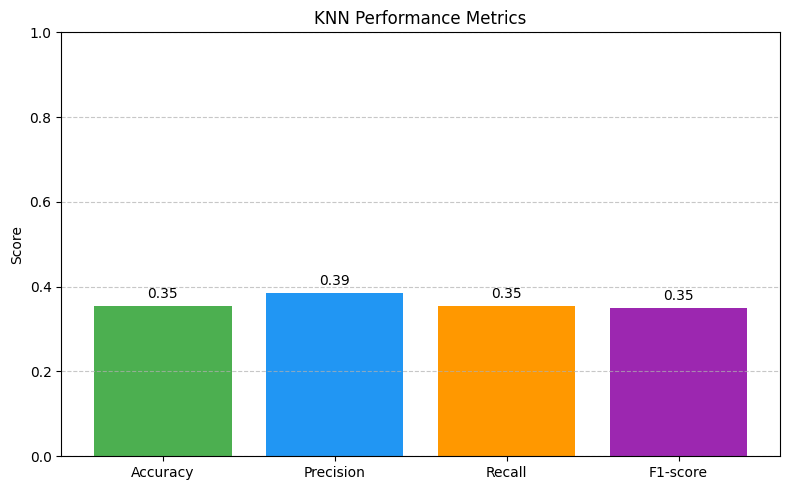

Accuracy:  0.3542
Precision: 0.3851
Recall:    0.3542
F1-score:  0.3487

Classification Report:

              precision    recall  f1-score   support

           0       0.24      0.39      0.30       160
           1       0.17      0.32      0.22       160
           2       0.41      0.68      0.51       160
           3       0.23      0.34      0.27       160
           4       0.39      0.32      0.35       160
           5       0.48      0.63      0.55       160
           6       0.42      0.56      0.48       160
           7       0.23      0.16      0.19       160
           8       0.38      0.31      0.34       160
           9       0.32      0.26      0.29       160
          10       0.60      0.38      0.46       160
          11       0.67      0.32      0.43       160
          12       0.38      0.14      0.21       160
          13       0.55      0.38      0.45       160
          14       0.31      0.12      0.18       160

    accuracy                         

In [4]:
import os
import cv2
import numpy as np
import joblib
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

# ================================
# Parameter settings
# ================================
radius = 3
n_points = 8 * radius
METHOD = 'uniform'

# ================================
# Extract LBP features
# ================================
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, n_points + 3),
                           range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# ================================
# Load dataset and extract features
# ================================
def load_lbp_dataset(dataset_path):
    data = []
    labels = []
    label_names = []

    for label in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, label)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))
            features = extract_lbp_features(img)
            data.append(features)
            labels.append(label)  # Keep string labels
            label_names.append(label)

    # Convert string labels to numbers
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    return np.array(data), np.array(labels_encoded), le

# ================================
# Model Training and Evaluation
# ================================
def train_and_evaluate(X_train, X_test, y_train, y_test, classifier='knn', save_model=False, model_filename="model.pkl"):
    if classifier == 'knn':
        model = KNeighborsClassifier(n_neighbors=3)
    elif classifier == 'svm':
        model = SVC(kernel='linear')
    else:
        raise ValueError("Classifier must be 'knn' or 'svm'")

    model.fit(X_train, y_train)

    # Save model if required
    if save_model:
        joblib.dump(model, model_filename)
        print(f"Model saved as {model_filename}")

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n Results for {classifier.upper()}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    plot_metrics(acc, prec, rec, f1, classifier_name=classifier.upper())

def plot_metrics(acc, prec, rec, f1, classifier_name="Classifier"):
    metrics = [acc, prec, rec, f1]
    names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    colors = ['#4caf50', '#2196f3', '#ff9800', '#9c27b0']

    plt.figure(figsize=(8, 5))
    plt.bar(names, metrics, color=colors)
    plt.ylim(0, 1)
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
    plt.title(f"{classifier_name} Performance Metrics")
    plt.ylabel("Score")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ================================
# Load a saved model
# ================================
def load_model(model_filename="model.pkl"):
    if os.path.exists(model_filename):
        model = joblib.load(model_filename)
        print(f"Model loaded from {model_filename}")
        return model
    else:
        print(f"Model file {model_filename} does not exist.")
        return None

# ================================
# Main function
# ================================
def main(dataset_path, classifier='knn', save_model=False, model_filename="model.pkl"):
    X, y, _ = load_lbp_dataset(dataset_path)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # If a model already exists, load it; otherwise, train a new model
    model = load_model(model_filename)
    if model is None:
        train_and_evaluate(X_train, X_test, y_train, y_test, classifier, save_model, model_filename)
    else:
        # If model exists, evaluate it on test data
        y_pred = model.predict(X_test)
        print(f"\nResults for loaded model:")
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        plot_metrics(acc, prec, rec, f1, classifier_name=classifier.upper())

        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1-score:  {f1:.4f}")
        print("\nClassification Report:\n")
        print(classification_report(y_test, y_pred, zero_division=0))

# ================================
# Execute code
# ================================
dataset_path = 'Aerial_Landscapes'  # Replace with your dataset path
main(dataset_path, classifier='knn', save_model=True, model_filename="knn_model.pkl")  # Optional 'knn' or 'svm'


Model loaded from svm_model.pkl

Results for loaded model:


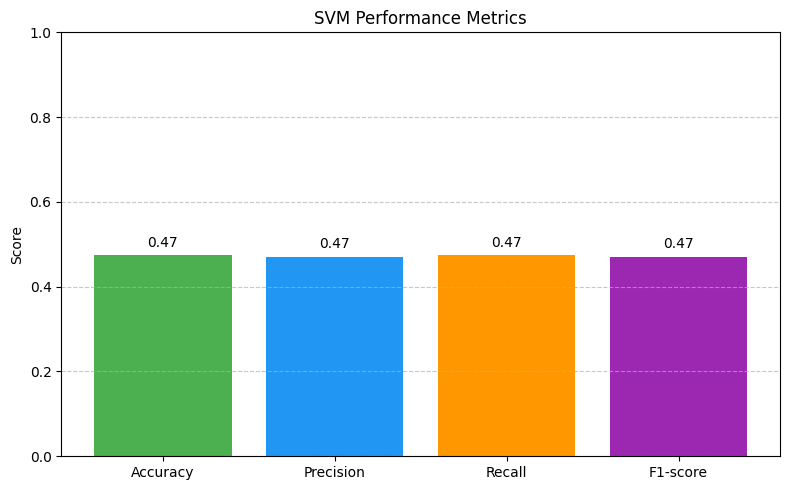

Accuracy:  0.4746
Precision: 0.4704
Recall:    0.4746
F1-score:  0.4707

Classification Report:

              precision    recall  f1-score   support

           0       0.38      0.43      0.40       160
           1       0.35      0.29      0.32       160
           2       0.59      0.62      0.60       160
           3       0.40      0.43      0.41       160
           4       0.45      0.47      0.46       160
           5       0.62      0.64      0.63       160
           6       0.53      0.61      0.57       160
           7       0.34      0.28      0.30       160
           8       0.47      0.39      0.42       160
           9       0.35      0.44      0.39       160
          10       0.66      0.67      0.67       160
          11       0.64      0.59      0.61       160
          12       0.36      0.34      0.35       160
          13       0.63      0.69      0.66       160
          14       0.28      0.23      0.25       160

    accuracy                         

In [5]:
dataset_path = 'Aerial_Landscapes'  # Replace with dataset path
main(dataset_path, classifier='svm', save_model=True, model_filename="svm_model.pkl")